In [1]:
#Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator
from qiskit.providers.aer.noise import NoiseModel, pauli_error
from qiskit.providers.fake_provider import FakeVigoV2
from qiskit.providers.aer import Aer, AerSimulator
from random import random

#python imports
from random import choice, choices
from itertools import product, permutations, cycle
from scipy.optimize import curve_fit, nnls
from matplotlib import pyplot as plt
import numpy as np

plt.style.use("ggplot")

In [2]:
def remove_Identity(pauli_list):
    new_list = []
    for i in pauli_list:
        new_list.append(i)
    new_list.remove(Pauli('I'*len(pauli_list[0])))
    return new_list

In [3]:
def get_index(qc, inst, i=None):
    if i:
        qubit = inst.qubits[i]
        index = -1
        for register in qc.qregs:  # Assuming you're using `QuantumCircuit`
            if qubit in register:
                index = register.index(qubit)
                break
        return index
    else:
        qubits = inst.qubits
        indexes = []
        for qubit in qubits:
            index = -1
            for register in qc.qregs:  # Assuming you're using `QuantumCircuit`
                if qubit in register:
                    index = register.index(qubit)
                    break
            indexes.append(index)
        return indexes

In [4]:
from tutorial_notebooks.testrun.TrotterExample import make_initial_Circuit
backend = FakeVigoV2()
circuit = make_initial_Circuit([0,1,2,3], 4, backend, 2)[0]
print(circuit)

                                                                               »
ancilla_0 -> 0 ────────────────────────────────────────────────────────────────»
               ┌─────────┐┌────┐┌──────────────────────┐┌────┐┌──────────┐┌───┐»
      q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├┤ X ├»
               ├─────────┤├────┤├──────────────────────┤├────┤├──────────┤└─┬─┘»
      q_0 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├──■──»
               ├─────────┤├────┤├──────────────────────┤├────┤├──────────┤     »
      q_2 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├──■──»
               ├─────────┤├────┤├──────────────────────┤├────┤├──────────┤┌─┴─┐»
      q_3 -> 4 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├┤ X ├»
               └─────────┘└────┘└──────────────────────┘└────┘└──────────┘└───┘»
«                                                         
«ancilla_0 -> 0 ──────────────────────────────────

In [5]:
num = 4  #number of errors
#singlequbit_errorops = choices(remove_Identity(pauli_basis(1)), k=num)
#twoqubit_errorops = choices(remove_Identity(pauli_basis(2)), k=num) #choose random pauli errors
singlequbit_errorops = [Pauli('Y'), Pauli('Z'), Pauli('X')]
twoqubit_errorops = [Pauli('YZ'), Pauli('IY'), Pauli('YY'), Pauli('XY')]
#singlequbit_errorprobs = [random()*.1/(num*10) for op in singlequbit_errorops] #assign random probabilities
#twoqubit_errorprobs = [random()*.1/num for op in twoqubit_errorops] #assign random probabilities
singlequbit_errorprobs = [0.0018781587123864844, 0.00037277073796095685, 0.0015945514328675244]
twoqubit_errorprobs = [0.008802700270751796, 0.0032989083407153896, 0.01917444731546973, 0.019520575974201]
#create normalized error model
singlequbit_error = pauli_error([(op, p) for op,p in zip(singlequbit_errorops, singlequbit_errorprobs)]+[(Pauli("I"), 1-sum(singlequbit_errorprobs))])
twoqubit_error = pauli_error([(op, p) for op,p in zip(twoqubit_errorops, twoqubit_errorprobs)]+[(Pauli("II"), 1-sum(twoqubit_errorprobs))])
noise_model = NoiseModel()
#add error model to two-qubit gates.
noise_model.add_all_qubit_quantum_error(singlequbit_error, ['id','rz', 'sx'])
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

print(dir(singlequbit_error))
print(singlequbit_error._probs)
print(singlequbit_error.circuits)
print(singlequbit_error.error_term)
print(singlequbit_error.probabilities)
print(singlequbit_error.to_dict())

['_ATOL_DEFAULT', '_MAX_TOL', '_RTOL_DEFAULT', '__abstractmethods__', '__add__', '__and__', '__array_priority__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__matmul__', '__module__', '__ne__', '__neg__', '__new__', '__pow__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '__xor__', '_abc_impl', '_circs', '_compose_circ', '_enlarge_qreg', '_id', '_input_dim', '_op_shape', '_output_dim', '_probs', '_qargs', '_to_circuit', 'atol', 'circuits', 'compose', 'copy', 'dim', 'dot', 'error_term', 'expand', 'id', 'ideal', 'input_dims', 'num_qubits', 'number_of_qubits', 'output_dims', 'power', 'probabilities', 'qargs', 'reshape', 'rtol', 'set_atol', 'set_rtol', 'size', 'tensor', 'to_dict', 'to_instruction', 'to_quantum

In [6]:
op = Pauli('XY')
indexes= [2,3]
identity_string = 'I'*5
temp_string = (identity_string[:indexes[0]] + "".join(reversed(str(op)))[0]+ identity_string[indexes[0]+1:])
op = Pauli("".join(reversed(temp_string[:indexes[1]] + "".join(reversed(str(op)))[1]+ temp_string[indexes[1]+1:])))
print(op)

IXYII


In [7]:
singlequbit_error_template = [(op, p) for op,p in zip(singlequbit_errorops, singlequbit_errorprobs)]+[(Pauli("I"), 1-sum(singlequbit_errorprobs))]
twoqubit_error_template = [(op, p) for op,p in zip(twoqubit_errorops, twoqubit_errorprobs)]+[(Pauli("II"), 1-sum(twoqubit_errorprobs))]
def get_error_for_circuit(circuit, twoqubit_error_template, singlequbit_error_template):
    def mul_Pauli(pauli1, pauli2):
        result = pauli1.compose(pauli2)
        nophase = Pauli((result.z, result.x))
        return nophase

    num_qubits = backend.num_qubits
    identity_string = 'I'*num_qubits
    error_state = {Pauli(identity_string): 1}
    for inst in circuit:
        temp_error_state = {}
        indexes = get_index(circuit, inst)
        if len(indexes) == 1:
            index = indexes[0]
            for (op, p) in singlequbit_error_template:
                op = Pauli("".join(reversed(identity_string[:index] + str(op)+ identity_string[index+1:])))
                for og_op in error_state:
                    og_p = error_state[og_op]
                    new_op = mul_Pauli(op, og_op)
                    temp_error_state[new_op] = temp_error_state.get(new_op, 0) + p*og_p
        elif len(indexes) == 2:
            for (op, p) in twoqubit_error_template:
                temp_string = (identity_string[:indexes[0]] + "".join(reversed(str(op)))[0]+ identity_string[indexes[0]+1:])
                op = Pauli("".join(reversed(temp_string[:indexes[1]] + "".join(reversed(str(op)))[1]+ temp_string[indexes[1]+1:])))
                for og_op in error_state:
                    og_p = error_state[og_op]
                    new_op = mul_Pauli(op, og_op)
                    temp_error_state[new_op] = temp_error_state.get(new_op, 0) + p*og_p
        else:
            if inst.operation.name == 'barrier':
                continue
            raise Exception(inst, "Too many qubits")
        error_state = temp_error_state
    return [(op, error_state[op]) for op in error_state]

error_state = get_error_for_circuit(circuit, twoqubit_error_template, singlequbit_error_template)
total_chance = 0
for (op, p) in error_state:
    total_chance += p
print(total_chance)
print(twoqubit_error_template)
print(error_state)

0.9999999999999993
[(Pauli('YZ'), 0.008802700270751796), (Pauli('IY'), 0.0032989083407153896), (Pauli('YY'), 0.01917444731546973), (Pauli('XY'), 0.019520575974201), (Pauli('II'), 0.9492033680988621)]
[(Pauli('IIYII'), 0.011809681661584722), (Pauli('IIYXI'), 0.027784675912032833), (Pauli('IIYZI'), 0.0008460818066588559), (Pauli('IIYYI'), 0.02750003352778472), (Pauli('IIZII'), 0.0015855406038220732), (Pauli('IIZXI'), 0.0002700231586283499), (Pauli('IIZZI'), 0.00013843688534843156), (Pauli('IIZYI'), 0.012689734726298417), (Pauli('IIXII'), 0.005650363414168435), (Pauli('IIXXI'), 0.00011631308860911234), (Pauli('IIXZI'), 0.0002792522564189474), (Pauli('IIXYI'), 0.00032644269379642784), (Pauli('IIIII'), 0.6716673585937918), (Pauli('IIIXI'), 0.0071006811213633345), (Pauli('IIIZI'), 0.0024323310047817542), (Pauli('IIIYI'), 0.013451774426449292), (Pauli('IXYII'), 0.001248742369460765), (Pauli('IXYXI'), 0.00030911127818431357), (Pauli('IXYZI'), 0.0011528598351968453), (Pauli('IXYYI'), 0.00075796

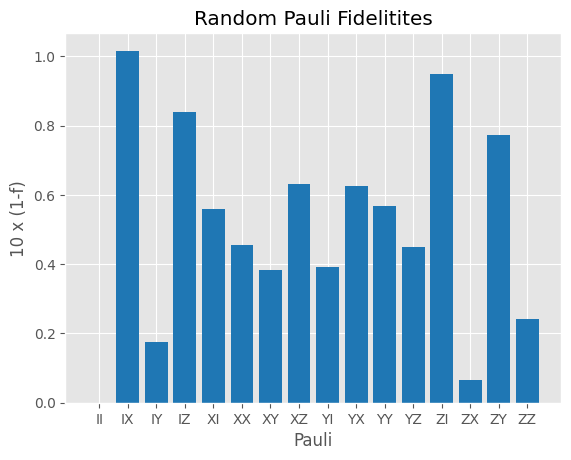

In [8]:
transfer_matrix = PTM(twoqubit_error.to_quantumchannel()).data #Find out more about this
for i,pauli in enumerate(pauli_basis(2)):
    plt.bar(pauli.to_label(), 10*(1-transfer_matrix[i][i]).real, color="tab:blue")

plt.title("Random Pauli Fidelitites")
plt.xlabel("Pauli")
plt.ylabel("10 x (1-f)")
plt.show()

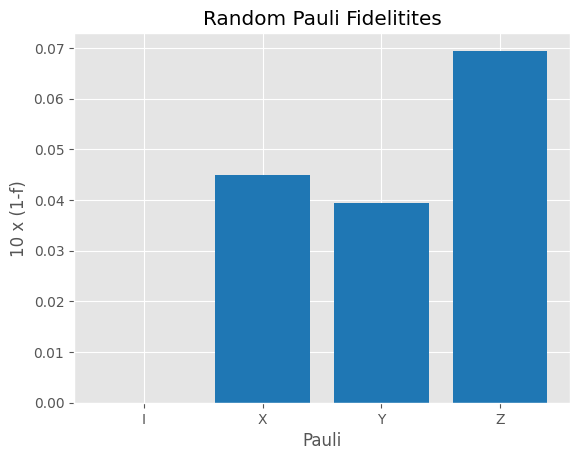

In [9]:
real_errors = {}
transfer_matrix = PTM(singlequbit_error.to_quantumchannel()).data #Find out more about this
for i,pauli in enumerate(pauli_basis(1)):
    real_errors[pauli] = transfer_matrix[i][i]
    plt.bar(pauli.to_label(), 10*(1-transfer_matrix[i][i]).real, color="tab:blue")

plt.title("Random Pauli Fidelitites")
plt.xlabel("Pauli")
plt.ylabel("10 x (1-f)")
plt.show()